# 6. 결정 트리

In [7]:
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys


- 결정트리는 랜덤 포레스트의 기본 구성요소이자, 매우 복잡한 데이터셋도 학습할 수 있는 강력한 알고리즘이다.  
- 가장 큰 장점은, 데이터 전처리가 거의 필요하지 않다는 점이다!

# 6.1 결정트리 학습과 시각화

In [27]:
from sklearn.datasets import load_iris #데이터 로드 
from sklearn.tree import DecisionTreeClassifier #결정트리 모듈 가져오기

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42) #결정트리 모델 생성
#max_depth -> tree의 maximum depth를 말한다. 
#max_depth 설정 안하면 모든 잎들이 pure해지거나, min_sample보다 적은 잎을 가진 때까지 노드들이 expand 한다.
#min_samples: internal node를 나누기 위한 최소 샘플 갯수를 말한다. int or float으로 설정 가능. default = 2
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [15]:
!pip install graphviz

# 6.2 예측하기

- 과정  
1. 루트 노드에서 시작해서, 꽃잎 길이를 판단.  
    - 2.45cm보다 짧다면 왼쪽의 자식 노드(child node)로 이동.  
        - 이 때, 이 노드가 리프 노드(leaf node, 자식을 가지지 않는 노드)이므로 추가적 검사 안함.
    - 아니라면 오른쪽의 자식 노드로 이동
2. 다시 꽃잎 길이를 판단.
    - 2.45cm를 기준으로 왼쪽 or 오른쪽
   - 반복

### 노드의 sample 속성, value 속성 , gini 속성 
1. sample 속성: 얼마나 많은 훈련 샘플이 적용되었는지 count한 것이다.  
2. value 속성: 노드에서 각 클래스에 얼마나 많은 훈련 샘플이 있는지 알려준다.  
3. gini 속성: 불순도(impurity)를 측정한다.  
    - 모든 샘플이 같은 클래스: gini = 0(순수하다)  
    - 불순도 계산 -> 지니 불순도: $G_i = 1 -\sum^n_{k=1}p_{i,k}^2$

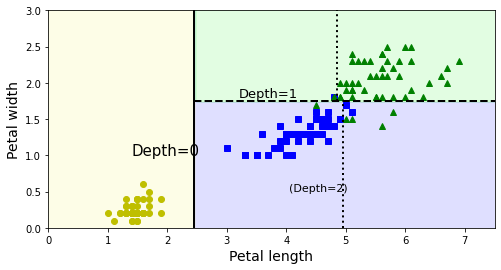

In [19]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

### 모델 해석 - 블랙박스와 화이트박스  
- 화이트박스: 직관적이고 결정 방식을 이해하기 쉬운 모델  
- 블랙박스는 화이트박스의 반대  
    - 성능이 뛰어나고 연산과정을 확인할 수 있지만, 왜 그렇게 예측했는지 설명하기 어려움

# 6.3 클래스 확률 추정

- 결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수 있다.

In [21]:
#길이가 5cm이고 너비가 1.5cm인 꽃잎이 어느 클래스에 속할지 확률을 추정
tree_clf.predict_proba([[5, 1.5]]) 
tree_clf.predict([[5, 1.5]])

array([1])

# 6.4 CART 훈련 알고리즘

- 사이킷런은 결정 트리 훈련을 위해 CART알고리즘을 사용
- CART = classification and regression tree
    - 훈련 세트를 하나의 특성 k의 임계값을 활용하여 서브셋으로 나눈다.(위 예에서는 꽃잎의 길이가 2.45cm가 임계값이 되었다.)  
    - 특성 k와 그 임계값을 고르기 위해, 가장 순수한 서브셋으로 나눌 수 있는 짝을 찾는다.  
    #### 분류에 대한 CART의 비용함수  
    - $J(k,t_k) = {m_{left} \over m}G_{left} + {m_{right}\over m }G_{right}$  
    - 이 때,  
        - $G_{left/right}$는 왼쪽/오른쪽 서브셋의 불순도  
        - $m_{left/right}$는 왼쪽/오른쪽 서브셋의 샘플 수

#### 탐욕적 알고리즘(greedy algorithm)  
맨 위 루트 노드에서 최적의 분할을 찾으며, 각 단계에서 계속해서 반복.  
현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있을지 없을지는 고려하지 않는다.  
이러한 탐욕적 알고리즘은 최적의 솔루션을 보장하지 않는다!

# 6.5 계산 복잡도

- 균형 이진 트리에서, 깊이가 $d$라면 리프 노드의 개수는 $2^d$개.  
    - 리프 노드의 갯수가 $m$개 만큼 있다면, 트리의 깊이는 $\log_2(m)$이다.  
    - 트리의 깊이만큼의 노드를 거쳐야 탐색이 종료.
--- 
- 각 노드에서 모든 샘플의 모든 특성을 고려한다고 하면,  
    - 계산복잡도 =  $n * m\log_2(m)$이다.

# 6.6 지니 불순도 또는 엔트로피?


- 지니불순도 대신 criterion 매개변수를 'entropy'로 지정하여 엔트로피 불순도를 사용할 수 있다.
     - 엔트로피 불순도: $H_i = -\sum_{k=1}^nP_{i,k}\log_2(P_{i,k})$

- 어떤 것을 사용해야 할까?  
    - 실제로는 큰 차이 없음 -> 지니 불순도가 계산이 조금 더 빠르다.  
    - 엔트로피는 조금 더 균형 잡힌 트리를 만들 수 있다.
    
 

# 6.7 규제 매개변수

 - 결정 트리는 모델 파라미터의 수가 훈련 전에 결정되지 않는다.(비파라미터 모델)
     - 과대적합 될 가능성이 크다. 그래서 자유도를 제한해야함(규제를 해야함)
     1. max_depth: 트리의 최대 깊이를 조절
     2. min_samples_split: 분할되기 위해 노드가 가져야하는 최소 샘플 수 
     3. min_samples_leaf: 리프 노드가 가져야 할 최소 샘플 수
     4. min_weight_fraction_laef: min_samples_leaf와 같지만 가중치가 부여된 전체 샘플 수에서의 비율
     5. max_leaf_nodes: 리프 노드의 최대 수
     6. max_features: 각 노들에서 분할에 사용할 특성의 최대 수  
       
     - min_ 매개변수 증가 & max_매개변수 감소 -> 규제가 커진다.

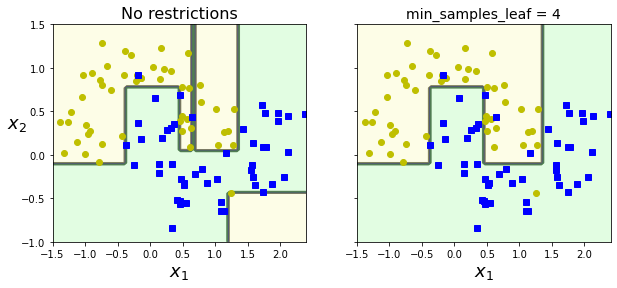

In [24]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

plt.show()

 - 오른쪽은 min_samples_leaf = 4로 지정 => 과대적합되지 않음(일반화 성능이 더 좋다)

- 가지치기(pruning) -> 제한 없이 결정 트리를 훈련시키고 불필요한 노드를 제거하는 방법  
    - 카이제곱 검정 등을 사용(통계적 방법)

# 6.8 회귀

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

- 앞의 DicisionTreeClassifier와 가장 큰 차이점은 각 노드에서 클래스를 예측하는 대신 어떤 값을 예측한다는 것이다.

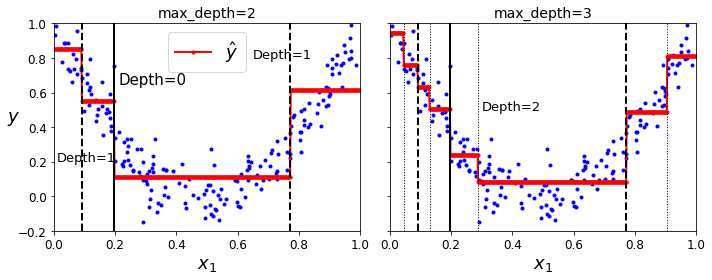

- CART알고리즘은 MSE를 최소화하도록 분할한다.

# 6.9 불안정성

- 결정 트리는 계단 모양의 결정 경계를 만든다.(모든 분할은 축에 수직이다)
    - 훈련 세트의 회전에 민감하다.

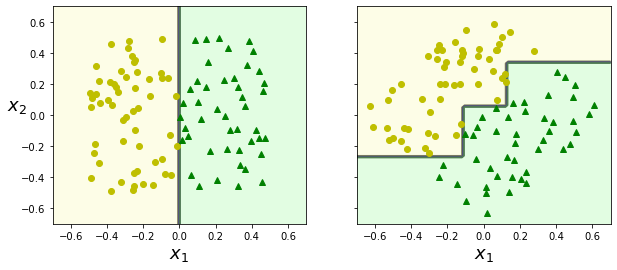

In [29]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

plt.show()

- 위 그림을 보면, 오른쪽의 결정트리는 왼쪽의 데이터셋을 45도 회전시킨 것이다.  
    - 잘 학습하긴 했지만, 오른쪽 모델은 일반화 하기 힘들 듯  
    - PCA기법을 사용하면 회전 민감 문제를 해결할 수 있다.(더 좋은방향으로 회전시키기)

- 결정 트리는 또한  훈련 세트의 세부사항에 민감하다  
    - random_state 같은걸 지정하지 않으면,,,

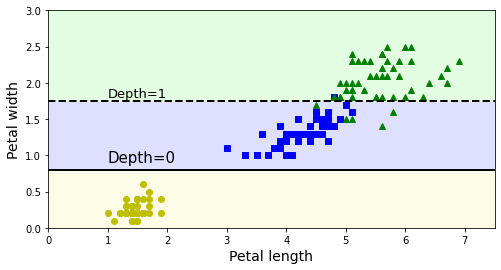

In [34]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()